# Run Training

This script runs the training loop from the `train.py` script based on the given arguments. Training metrics can then be plotted over the epochs.

In [1]:
import os, argparse, pathlib
import time
import copy
import pandas as pd
import numpy as np
 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

import warnings
warnings.filterwarnings('ignore')

from darwin_net.architectures.DarwinNet_groups4 import DarwinNetV2
from darwinai.torch.builder import build_model  # , BlockSpec, BuildMetrics
from darwinai.builder import BlockSpec
from darwin.enums.enums import BuildMetrics
 
from dataset import get_dataloader


NUM_CLASSES = 3
BATCH_SIZE = 16

datadir = '../montefiore_severity/CXR'
trainfile = '../../alex.maclean/montefiore_severity/nov_29_split_80_10_10/train_mtf_sev.txt'
validfile = '../../alex.maclean/montefiore_severity/nov_29_split_80_10_10/valid_mtf_sev.txt'
testfile = '../../alex.maclean/montefiore_severity/nov_29_split_80_10_10/test_mtf_sev.txt'
name = 'covid_net_model'
model_type = 'darwinnetv2'
modelfile = None

# Check which metric to use
measure = 'geo' 

bin_map = np.array([[0.0,3.0], [3.0,6.0], [6.0,8.0]])
is_classification = True
 
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
 
# output path
output_path = './output/'
run_id = name + '_' + model_type + f'-{measure}'
run_path = output_path + run_id
pathlib.Path(run_path).mkdir(parents=True, exist_ok=True)
print('Output: ' + run_path)
 

train_dataloader = get_dataloader(
        csv_file=trainfile,
        datadir=datadir,
        batch_size=BATCH_SIZE,
        transform='base',
        bin_map=bin_map,
        is_classification=is_classification)
 
valid_dataloader = get_dataloader(
        csv_file=validfile,
        datadir=datadir,
        batch_size=1,
        transform=None,
        bin_map=bin_map,
        is_classification=is_classification) # no augmentations
 
dataloaders = {'train':train_dataloader, 'val':valid_dataloader}
dataset_sizes = {'train':len(train_dataloader)*BATCH_SIZE, 'val':len(valid_dataloader)}
 
train_acc = []
train_loss = []
val_acc = []
val_loss = []
    
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    '''taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html '''
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())

    best_acc = 0.0
 
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
 
        epoch_start = time.time()
 
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
 
            running_loss = 0.0
            running_corrects = 0
 
            for i, sample_batch in enumerate(dataloaders[phase]):
                inputs = sample_batch['image'].to(device, dtype=torch.float)
                # CXR sev to get OPC or GEO
                labels = sample_batch['label'][measure].to(device, dtype=torch.long)
                
                optimizer.zero_grad()
 
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
 
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
 
                if i % 100 == 0 and phase == 'train':
                    phase_batch = BATCH_SIZE if phase == 'train' else 1
                    print('Batch {} of {}'.format(i, dataset_sizes[phase]/phase_batch))
            if phase == 'train':
                scheduler.step()
 
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
             
            if phase == 'train':
                train_acc.append(epoch_acc)
                train_loss.append(epoch_loss)
            else:
                val_acc.append(epoch_acc)
                val_loss.append(epoch_loss)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print('Epoch took {} seconds'.format(time.time() - epoch_start))
 
        print()
 
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
 
if model_type == 'resnet':
    model_ft = models.resnet50(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    
    print(num_ftrs)

    model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)

    # Load model weights
    if modelfile:
        print("Using model: " + str(modelfile))
        model_ft.load_state_dict(torch.load(os.path.join(modelfile, 'model')))
else:
    gsbuild_config = {
        "blockspecs": [
            BlockSpec(channels=40, depth=3),
            BlockSpec(channels=84, depth=4),
            BlockSpec(channels=176, depth=7),
            BlockSpec(channels=372, depth=3),
            ]
        }
    INPUT_SHAPE = [480, 480, 3]

    model_ft = DarwinNetV2(gsbuild_config['blockspecs'], INPUT_SHAPE, NUM_CLASSES)

model_ft = model_ft.to(device)
 
# initial basic training parameters
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
 
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)
 
torch.save(model_ft.state_dict(), os.path.join(run_path, 'model'))
 



22-02-18 13:17:55.245|INFO|<frozen importlib._bootstrap>|_load_backward_compatible|618|Licenser|License is already activated.


The DarwinAI troubleshooting mode is active and debug logs are stored at /home/tia.tuinstra/COVID-Net-pt/logs/darwin_sdk_2022-02-18T13:17:55.debug.
Output: ./output/covid_net_model_darwinnetv2-geo
Epoch 0/19
----------
Batch 0 of 120.0
Batch 100 of 120.0
train Loss: 1.0237 Acc: 0.4740
val Loss: 2.0555 Acc: 0.3275
Epoch took 117.3162043094635 seconds

Epoch 1/19
----------
Batch 0 of 120.0
Batch 100 of 120.0
train Loss: 0.8978 Acc: 0.5802
val Loss: 2.3046 Acc: 0.2751
Epoch took 116.53747129440308 seconds

Epoch 2/19
----------
Batch 0 of 120.0
Batch 100 of 120.0
train Loss: 0.8353 Acc: 0.6062
val Loss: 1.6646 Acc: 0.3581
Epoch took 116.72704362869263 seconds

Epoch 3/19
----------
Batch 0 of 120.0
Batch 100 of 120.0
train Loss: 0.8432 Acc: 0.5854
val Loss: 0.9638 Acc: 0.5633
Epoch took 117.27944946289062 seconds

Epoch 4/19
----------
Batch 0 of 120.0
Batch 100 of 120.0
train Loss: 0.8323 Acc: 0.6208
val Loss: 1.6318 Acc: 0.4323
Epoch took 118.67211747169495 seconds

Epoch 5/19
--------

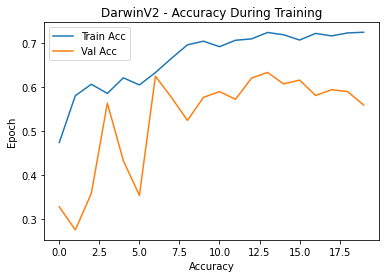

Text(0.5, 1.0, 'Darwin V2 - Loss During Training')

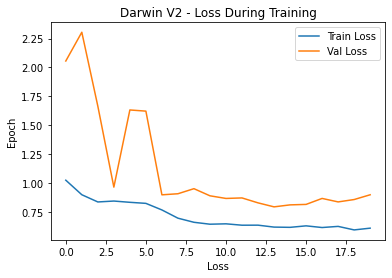

In [3]:
import matplotlib.pyplot as plt


plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['Train Acc', 'Val Acc'])
plt.ylabel('Epoch')
plt.xlabel('Accuracy')
plt.title('DarwinV2 - Accuracy During Training')

plt.show()

plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['Train Loss', 'Val Loss'])
plt.ylabel('Epoch')
plt.xlabel('Loss')
plt.title('Darwin V2 - Loss During Training')